In [1]:
import pandas as pd
import pickle

In [2]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI
from pandas import read_pickle
import plotly.express as px

In [3]:
close_prices = read_pickle('/Users/georgii_nigm/Applications/VS Code projects/academic_causal_portfolio/cleaned/close_prices_fed.pkl')

In [5]:
close_prices_crop = close_prices.iloc[close_prices.index >'2000-01-01',10:]

In [22]:
close_prices_crop

,PSA,WELL,NEE,DUK,D,SO,EXC,AEP,FEDFUNDS_20230703
Date,,,,,,,,,
2000-01-03,9.379152,3.650212,2.432440,14.275661,7.313035,4.663520,5.175283,11.244986,5.30
2000-01-04,9.379152,3.635375,2.476665,14.497560,7.492868,4.714765,5.137091,11.379117,5.30
2000-01-05,9.456453,3.739242,2.557746,15.089304,7.696674,4.958190,5.385348,11.803882,5.30
2000-01-06,9.817185,3.932138,2.557746,15.496113,7.780593,4.971004,5.394897,11.870950,5.30
2000-01-07,9.946029,3.991493,2.631458,15.902940,7.780593,5.060689,5.394897,12.027439,5.30
...,...,...,...,...,...,...,...,...,...
2021-12-23,332.725739,79.005417,87.673065,97.089615,72.746956,62.755455,37.019855,82.137115,0.08
2021-12-27,338.554962,80.198273,88.272385,97.391342,72.831612,63.151558,37.237263,82.668770,0.08
2021-12-28,340.225739,80.856728,88.813690,98.598251,73.283119,63.877777,37.780773,83.741508,0.08


In [26]:
close_prices_crop.index = pd.to_datetime(close_prices_crop.index)

In [27]:
close_prices_crop.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=5535, freq=None)

In [29]:
filtered_df = close_prices_crop[close_prices_crop.index.day == 1]

In [30]:
filtered_df

NameError: name 'v' is not defined

(<Figure size 640x480 with 9 Axes>,
 array([<Axes: ylabel='PSA'>, <Axes: ylabel='WELL'>, <Axes: ylabel='NEE'>,
        <Axes: ylabel='DUK'>, <Axes: ylabel='D'>, <Axes: ylabel='SO'>,
        <Axes: ylabel='EXC'>, <Axes: ylabel='AEP'>,
        <Axes: ylabel='FEDFUNDS_20230703'>], dtype=object))

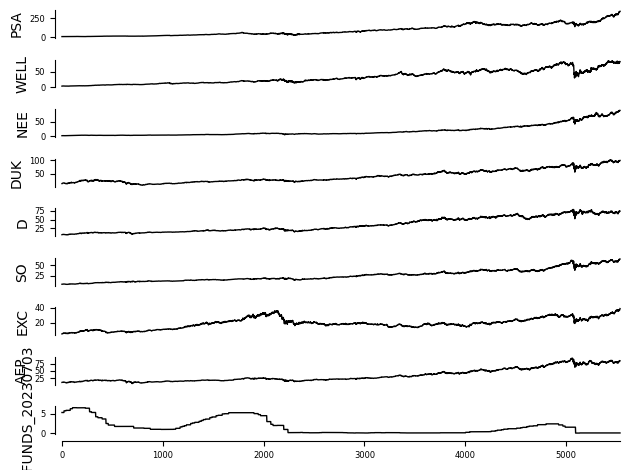

In [8]:
var_names=close_prices_crop.columns
dataframe = pp.DataFrame(close_prices_crop.values, var_names=var_names)
tp.plot_timeseries(dataframe)

# Stationarizing

In [ ]:
df_train = close_prices_crop

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(df):
    print('if p>0,5 - than ts is non-stationary\n')
    
    for stock in df.columns:
        result = adfuller(df[stock].values)
        if result[1] < 0.05:
            print(f'{stock}: stationary. p-value: %f' % result[1])
        if result[1] >= 0.05:
            print(f'{stock}: Non-Stationary. p-value: %f' % result[1])


    # print('ADF Statistics: %f' % result[0])
    # print('p-value: %f' % result[1])
    # print('Critical values:')
    # for key, value in result[4].items():
    #     print('\t%s: %.3f' % (key, value))


def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

In [ ]:
adf_test(close_prices_crop)

In [ ]:
df_train_transformed = df_train#.diff().dropna()

In [ ]:
adf_test(df_train_transformed)

# VAR

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
# model = VAR(df_train_transformed)
# for i in [2*x for x in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]:
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

In [ ]:
results = model.fit(maxlags=1, ic='aic')
results.summary()

In [ ]:
results.resid_corr

In [ ]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df_train_transformed.columns, out):
    print(col, ':', round(val, 2))

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)